In [45]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

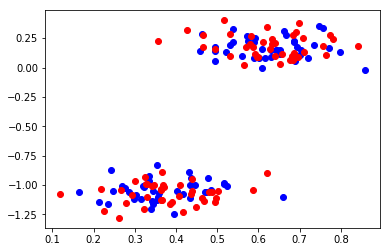

In [139]:
num_dims = 3
num_centroids = 2
num_samples = 40
num_batch = 32

data_points = []
test_points = []

for i in range(num_dims):
    centroids = np.random.normal(0, 1, [num_centroids, 1])
    
    samples = centroids + np.random.normal(
        0, 0.1, [num_centroids, num_samples])
    tests = centroids + np.random.normal(
        0, 0.1, [num_centroids, num_samples])
    
    data_points.append(samples.flatten())
    test_points.append(tests.flatten())
    
data_points = np.stack(data_points).T
test_points = np.stack(test_points).T

plt.plot(data_points[:, 0], data_points[:, 1], "bo")
plt.plot(test_points[:, 0], test_points[:, 1], "ro")

In [5]:
g = tf.Graph()
s = tf.Session(graph=g)

In [6]:
with g.as_default():
    
    
    # Has Shape: [samples, dims]
    data_feed = tf.placeholder(
        tf.float32, 
        shape=[None, None],
        name="data_feed")
    
    data_expand = tf.expand_dims(
        tf.expand_dims(
            data_feed, 
            axis=0), 
        axis=3)
    
    # Has Shape: [batch, dims]
    x_feed = tf.placeholder(
        tf.float32, 
        shape=[None, None],
        name="x_feed")
    
    x_expand = tf.expand_dims(
        tf.expand_dims(
            x_feed, 
            axis=1), 
        axis=3)
    
    # Has Shape: [dims, dims]
    H_feed = tf.placeholder(
        tf.float32, 
        shape=[None, None],
        name="H_feed")
    
    H_expand = tf.tile(
        tf.expand_dims(
            tf.expand_dims(
                H_feed, 
                axis=0), 
            axis=1), 
        [tf.shape(x_feed)[0], tf.shape(data_feed)[0], 1, 1])
    
    # Has Shape: [batch, samples, dims, 1]
    x_kde = x_expand - data_expand
    
    first_coeff = tf.pow((2.0 * np.pi), 
        tf.cast(
            -tf.shape(data_feed)[0] / 2,
            tf.float32))
    
    second_coeff = tf.pow(
        tf.matrix_determinant(H_feed), 
        -0.5)
    
    third_coeff = tf.exp(
        -0.5 * tf.matmul(
            tf.transpose(x_kde, [0, 1, 3, 2]), 
            tf.matmul(
                tf.matrix_inverse(H_expand), 
                x_kde)))
    
    third_coeff = tf.reduce_sum(
        third_coeff, 
        axis=[1, 2, 3])
    
    
    K_H = (first_coeff * second_coeff * third_coeff 
        / tf.cast(tf.shape(data_feed)[0], tf.float32))
    
g.finalize()

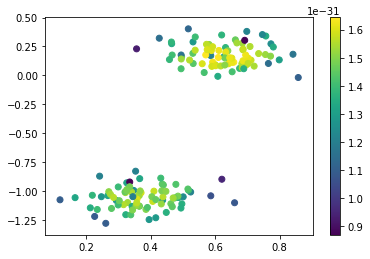

In [149]:
kernel = np.eye(num_dims)

results = s.run(
    K_H, 
    feed_dict={
        data_feed: data_points,
        x_feed: test_points,
        H_feed: 0.1 * kernel
    })

results2 = s.run(
    K_H, 
    feed_dict={
        data_feed: data_points,
        x_feed: data_points,
        H_feed: 0.1 * kernel
    })

plt.scatter(test_points[:, 0], test_points[:, 1], c=results)
plt.scatter(data_points[:, 0], data_points[:, 1], c=results2)
plt.colorbar()